In [1]:
import numpy as np
import os
import sys
import json
import tarfile
import urllib.request
from matplotlib import pyplot as plt
from utils import perfect_matching_vis, plot_tsp_path, download_url
%matplotlib inline

import torch

# Warcraft Shortest Path

Download dataset

In [ ]:

# warcraft_url = "https://edmond.mpdl.mpg.de/imeji/exportServlet?format=file&id=http://edmond.mpdl.mpg.de/imeji/item/PPjoEvUh9_PVTPSD"
# data_path = "warcraft_shortest_path.tar.gz"
# if not os.path.exists(data_path):
#     print("Downloading dataset...")
#     download_url(warcraft_url, data_path)

# print(f"Extracting {data_path} ...")
# f = tarfile.open(data_path, "r:gz")
# f.extractall(path=".")
# f.close()
# print("Extracted")


For the Warcraft Sortest Path dataset we have randomly genrated maps of different sizes with optimal shortest path from the top left vertex to the bottom right vertex. Each type of tile has a different cost, we also supply the costs used to generate the optimal shortest paths.

Train images shape:  (10000, 96, 96, 3)
Train labels shape:  (10000, 12, 12)
Weights shape: (10000, 12, 12)
Train weights [[1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 0.8 0.8 0.8]
 [1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2]
 [1.2 1.2 1.2 1.2 1.2 1.2 1.2 7.7 7.7 7.7 7.7 1.2]
 [1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 7.7 7.7 1.2 1.2]
 [0.8 0.8 0.8 0.8 0.8 1.2 1.2 1.2 1.2 1.2 1.2 0.8]
 [5.3 5.3 5.3 5.3 0.8 0.8 1.2 1.2 1.2 1.2 1.2 1.2]
 [5.3 5.3 5.3 5.3 0.8 0.8 1.2 9.2 9.2 9.2 1.2 1.2]
 [5.3 5.3 5.3 5.3 0.8 1.2 1.2 1.2 9.2 9.2 1.2 0.8]
 [5.3 5.3 5.3 5.3 0.8 0.8 0.8 1.2 1.2 1.2 1.2 0.8]
 [5.3 5.3 5.3 5.3 5.3 5.3 0.8 0.8 0.8 0.8 0.8 0.8]
 [5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 0.8 5.3]
 [5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 0.8 0.8]]


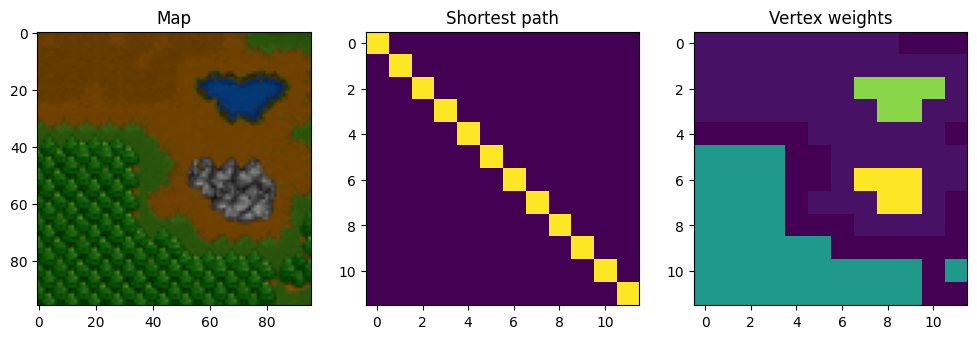

In [3]:
data_dir = 'warcraft_shortest_path/12x12/'

data_suffix = "maps"
train_prefix = "train"

train_inputs = np.load(os.path.join(data_dir, train_prefix + "_" + data_suffix + ".npy"))
train_weights = np.load(os.path.join(data_dir, train_prefix + "_vertex_weights.npy"))
train_labels = np.load(os.path.join(data_dir, train_prefix + "_shortest_paths.npy"))

#images = train_inputs.transpose(0,2,3,1).astype(np.uint8)
images = train_inputs

print("Train images shape: ", train_inputs.shape)
print("Train labels shape: ",  train_labels.shape)
print("Weights shape:", train_weights.shape)
idx = 10
im = images[idx]
label = train_labels[idx]
weights = train_weights[idx]

print("Image index", idx)
print("Train weights", weights)
fig, ax = plt.subplots(1,3, figsize=(12,12))

ax[0].imshow(im.astype(np.uint8))
ax[0].set_title("Map")
ax[1].imshow(label)
ax[1].set_title("Shortest path")
ax[2].set_title("Vertex weights")
ax[2].imshow(weights.astype(np.float32))

# Learned Cost Analysis

Compare the learned vertex costs from different loss functions (HammingLoss vs PathCostLoss) with the optimal costs.

In [6]:
# Add parent directory to path BEFORE importing
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now import from the main project directory
from models import get_model

def load_trained_model(results_path):
    """Load a trained model from results directory"""
    
    # Load the configuration
    config_path = os.path.join(results_path, 'settings.json')
    if not os.path.exists(config_path):
        print(f"Config file not found at {config_path}")
        return None, None
        
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    print(f"Found config for: {config.get('trainer_name', 'Unknown trainer')}")
    
    # Extract model parameters
    model_params = config['trainer_params']['model_params']
    
    # Metadata (simplified for 12x12 grid)
    metadata = {
        'output_features': 144,  # 12x12 grid
        'num_channels': 3
    }
    
    # Create model
    model = get_model(
        model_params['model_name'], 
        out_features=metadata['output_features'], 
        in_channels=metadata['num_channels'], 
        arch_params=model_params.get('arch_params', {})
    )
    
    # Try to load model weights
    model_path = os.path.join(results_path, 'model.pth')
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location='cpu'))
        print(f"✅ Loaded model weights from {model_path}")
        model.eval()
        return model, config
    else:
        print(f"⚠️ No model weights found at {model_path}")
        return None, config

In [9]:
# Load both models for comparison and analyze their training metrics
hamming_model, hamming_config = None, None
pathcost_model, pathcost_config = None, None

# Updated paths for models with saved weights
hamminglos_dir = '../results/warcraft_shortest_path_hammingoss_with_models'
pathcost_dir = '../results/warcraft_shortest_path_pathcostloss_with_models'

print("Looking for models with saved weights...")

if os.path.exists(hamminglos_dir):
    try:
        hamming_model, hamming_config = load_trained_model(hamminglos_dir)
        if hamming_model is not None:
            print("✅ HammingLoss model loaded successfully")
    except Exception as e:
        print(f"Failed to load HammingLoss model: {e}")

if os.path.exists(pathcost_dir):
    try:
        pathcost_model, pathcost_config = load_trained_model(pathcost_dir)
        if pathcost_model is not None:
            print("✅ PathCostLoss model loaded successfully")
    except Exception as e:
        print(f"Failed to load PathCostLoss model: {e}")

Looking for models with saved weights...


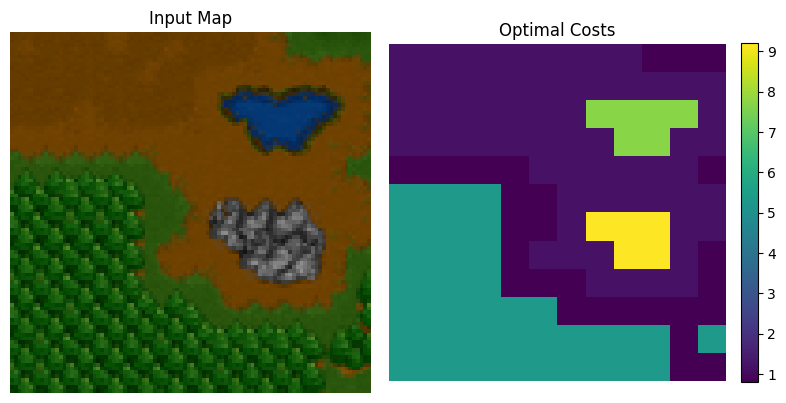

Example 10 Cost Statistics:
Optimal costs - Min: 0.800, Max: 9.203, Mean: 2.895


In [10]:
def get_learned_costs(model, input_image):
    """Get the learned vertex costs from a model"""
    if model is None:
        return None
    
    with torch.no_grad():
        # Convert numpy to tensor and add batch dimension
        if isinstance(input_image, np.ndarray):
            input_tensor = torch.FloatTensor(input_image).unsqueeze(0)
            # Ensure channel-first format (B, C, H, W)
            if input_tensor.shape[1] != 3:  # If not already channel-first
                input_tensor = input_tensor.permute(0, 3, 1, 2)
        else:
            input_tensor = input_image.unsqueeze(0)
        
        # Get model output (predicted costs)
        output = model(input_tensor)
        output = torch.abs(output)  # Make costs positive
        
        # Remove batch dimension
        output = output.squeeze(0)
        
        # The model already outputs in the correct grid format (12, 12)
        learned_costs = output
        
    return learned_costs.numpy()

# Function to visualize cost comparison
def visualize_cost_comparison(idx=10):
    """Compare learned costs vs optimal costs for a specific example"""
    
    # Get the data for comparison
    im = images[idx]
    optimal_costs = train_weights[idx]
    optimal_path = train_labels[idx]
    
    # Get learned costs from both models
    hamming_costs = get_learned_costs(hamming_model, im) if hamming_model else None
    pathcost_costs = get_learned_costs(pathcost_model, im) if pathcost_model else None
    
    # Set up the plot
    num_plots = 2 + (hamming_costs is not None) + (pathcost_costs is not None)
    fig, axes = plt.subplots(1, num_plots, figsize=(4*num_plots, 4))
    if num_plots == 1:
        axes = [axes]
    
    plot_idx = 0
    
    # Plot the map
    axes[plot_idx].imshow(im.astype(np.uint8))
    axes[plot_idx].set_title("Input Map")
    axes[plot_idx].axis('off')
    plot_idx += 1
    
    # Plot optimal costs
    im_optimal = axes[plot_idx].imshow(optimal_costs, cmap='viridis')
    axes[plot_idx].set_title("Optimal Costs")
    axes[plot_idx].axis('off')
    plt.colorbar(im_optimal, ax=axes[plot_idx], fraction=0.046, pad=0.04)
    plot_idx += 1
    
    # Plot HammingLoss learned costs
    if hamming_costs is not None:
        im_hamming = axes[plot_idx].imshow(hamming_costs, cmap='viridis')
        axes[plot_idx].set_title("HammingLoss\nLearned Costs")
        axes[plot_idx].axis('off')
        plt.colorbar(im_hamming, ax=axes[plot_idx], fraction=0.046, pad=0.04)
        plot_idx += 1
    
    # Plot PathCostLoss learned costs
    if pathcost_costs is not None:
        im_pathcost = axes[plot_idx].imshow(pathcost_costs, cmap='viridis')
        axes[plot_idx].set_title("PathCostLoss\nLearned Costs")
        axes[plot_idx].axis('off')
        plt.colorbar(im_pathcost, ax=axes[plot_idx], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Print cost statistics
    print(f"Example {idx} Cost Statistics:")
    print(f"Optimal costs - Min: {optimal_costs.min():.3f}, Max: {optimal_costs.max():.3f}, Mean: {optimal_costs.mean():.3f}")
    
    if hamming_costs is not None:
        print(f"HammingLoss costs - Min: {hamming_costs.min():.3f}, Max: {hamming_costs.max():.3f}, Mean: {hamming_costs.mean():.3f}")
        # Calculate correlation
        correlation = np.corrcoef(optimal_costs.flatten(), hamming_costs.flatten())[0, 1]
        print(f"HammingLoss correlation with optimal: {correlation:.3f}")
    
    if pathcost_costs is not None:
        print(f"PathCostLoss costs - Min: {pathcost_costs.min():.3f}, Max: {pathcost_costs.max():.3f}, Mean: {pathcost_costs.mean():.3f}")
        # Calculate correlation
        correlation = np.corrcoef(optimal_costs.flatten(), pathcost_costs.flatten())[0, 1]
        print(f"PathCostLoss correlation with optimal: {correlation:.3f}")

# Visualize first example
visualize_cost_comparison(idx=10)

Analyzing multiple examples...

--- Example 0 ---


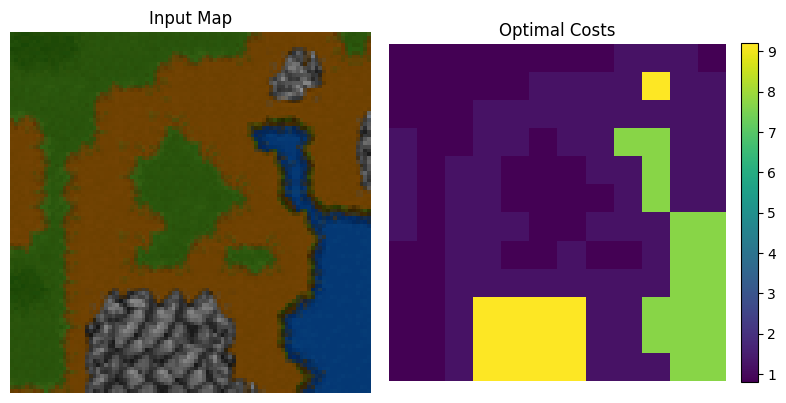

Example 0 Cost Statistics:
Optimal costs - Min: 0.800, Max: 9.203, Mean: 2.607

--- Example 1 ---


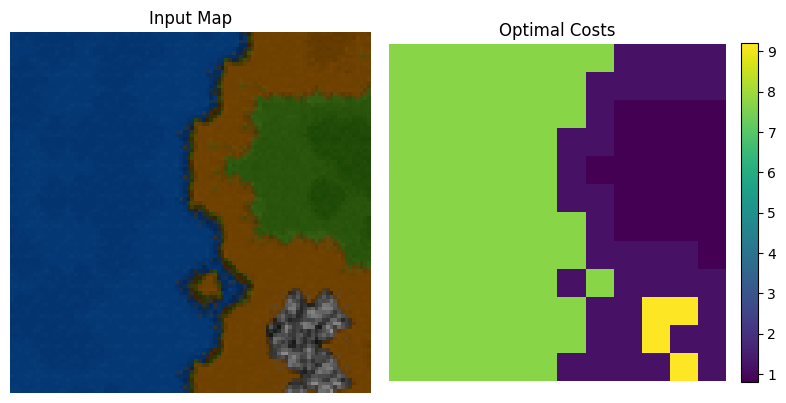

Example 1 Cost Statistics:
Optimal costs - Min: 0.800, Max: 9.203, Mean: 5.016

--- Example 2 ---


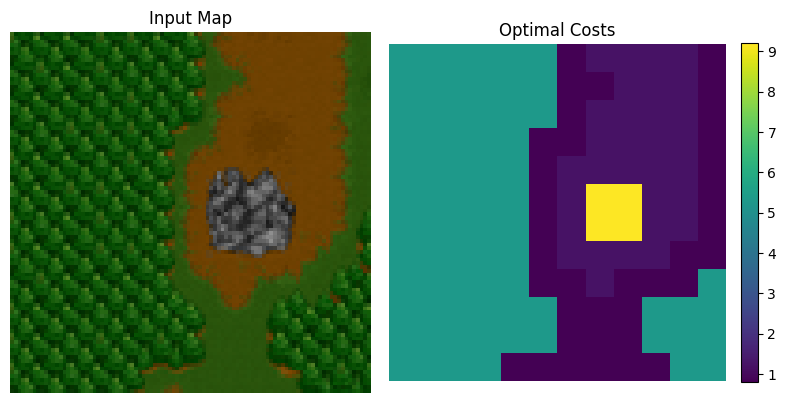

Example 2 Cost Statistics:
Optimal costs - Min: 0.800, Max: 9.203, Mean: 3.400

--- Example 3 ---


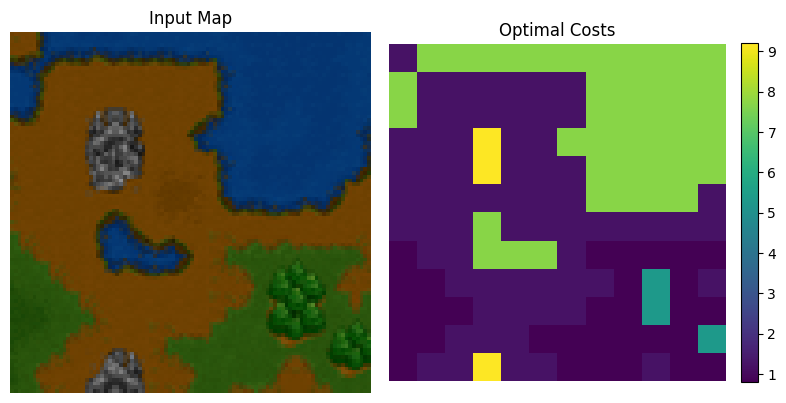

Example 3 Cost Statistics:
Optimal costs - Min: 0.800, Max: 9.203, Mean: 3.262

--- Example 4 ---


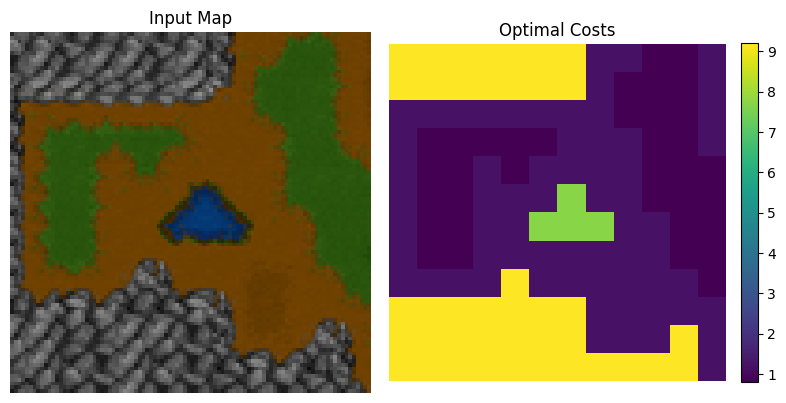

Example 4 Cost Statistics:
Optimal costs - Min: 0.800, Max: 9.203, Mean: 3.562

=== SUMMARY STATISTICS ===


In [11]:
# Analyze multiple examples
print("Analyzing multiple examples...")

num_examples = 5
correlations_hamming = []
correlations_pathcost = []

for i in range(num_examples):
    print(f"\n--- Example {i} ---")
    visualize_cost_comparison(idx=i)
    
    optimal_costs = train_weights[i]
    
    if hamming_model:
        hamming_costs = get_learned_costs(hamming_model, images[i])
        if hamming_costs is not None:
            corr = np.corrcoef(optimal_costs.flatten(), hamming_costs.flatten())[0, 1]
            correlations_hamming.append(corr)
    
    if pathcost_model:
        pathcost_costs = get_learned_costs(pathcost_model, images[i])
        if pathcost_costs is not None:
            corr = np.corrcoef(optimal_costs.flatten(), pathcost_costs.flatten())[0, 1]
            correlations_pathcost.append(corr)

# Summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
if correlations_hamming:
    print(f"HammingLoss - Average correlation: {np.mean(correlations_hamming):.3f} ± {np.std(correlations_hamming):.3f}")
if correlations_pathcost:
    print(f"PathCostLoss - Average correlation: {np.mean(correlations_pathcost):.3f} ± {np.std(correlations_pathcost):.3f}")

In [12]:
# Create scatter plots to analyze cost relationships
def create_cost_scatter_plots(num_examples=10):
    """Create scatter plots comparing learned costs vs optimal costs"""
    
    # Collect data from multiple examples
    optimal_all = []
    hamming_all = []
    pathcost_all = []
    
    for i in range(min(num_examples, len(images))):
        optimal_costs = train_weights[i].flatten()
        optimal_all.extend(optimal_costs)
        
        if hamming_model:
            hamming_costs = get_learned_costs(hamming_model, images[i])
            if hamming_costs is not None:
                hamming_all.extend(hamming_costs.flatten())
        
        if pathcost_model:
            pathcost_costs = get_learned_costs(pathcost_model, images[i])
            if pathcost_costs is not None:
                pathcost_all.extend(pathcost_costs.flatten())
    
    # Create scatter plots
    num_plots = (hamming_all != []) + (pathcost_all != [])
    if num_plots == 0:
        print("No models available for comparison")
        return
    
    fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 5))
    if num_plots == 1:
        axes = [axes]
    
    plot_idx = 0
    
    # HammingLoss scatter plot
    if hamming_all:
        optimal_subset = optimal_all[:len(hamming_all)]
        axes[plot_idx].scatter(optimal_subset, hamming_all, alpha=0.6, s=2, color='blue', label='Data points')
        
        # Add perfect correlation line
        min_val, max_val = min(optimal_subset + hamming_all), max(optimal_subset + hamming_all)
        axes[plot_idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect correlation')
        
        # Add trend line
        z = np.polyfit(optimal_subset, hamming_all, 1)
        p = np.poly1d(z)
        axes[plot_idx].plot(optimal_subset, p(optimal_subset), "g--", alpha=0.8, linewidth=2, label=f'Trend line (slope={z[0]:.3f})')
        
        axes[plot_idx].set_xlabel('Optimal Costs')
        axes[plot_idx].set_ylabel('HammingLoss Learned Costs')
        axes[plot_idx].set_title('HammingLoss: Learned vs Optimal Costs')
        axes[plot_idx].legend()
        axes[plot_idx].grid(True, alpha=0.3)
        
        # Calculate and display statistics
        corr = np.corrcoef(optimal_subset, hamming_all)[0, 1]
        mse = np.mean((np.array(optimal_subset) - np.array(hamming_all))**2)
        axes[plot_idx].text(0.05, 0.95, f'Correlation: {corr:.3f}\nMSE: {mse:.3f}', 
                          transform=axes[plot_idx].transAxes, 
                          bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8),
                          verticalalignment='top')
        plot_idx += 1
    
    # PathCostLoss scatter plot
    if pathcost_all:
        optimal_subset = optimal_all[:len(pathcost_all)]
        axes[plot_idx].scatter(optimal_subset, pathcost_all, alpha=0.6, s=2, color='orange', label='Data points')
        
        # Add perfect correlation line
        min_val, max_val = min(optimal_subset + pathcost_all), max(optimal_subset + pathcost_all)
        axes[plot_idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect correlation')
        
        # Add trend line
        z = np.polyfit(optimal_subset, pathcost_all, 1)
        p = np.poly1d(z)
        axes[plot_idx].plot(optimal_subset, p(optimal_subset), "g--", alpha=0.8, linewidth=2, label=f'Trend line (slope={z[0]:.3f})')
        
        axes[plot_idx].set_xlabel('Optimal Costs')
        axes[plot_idx].set_ylabel('PathCostLoss Learned Costs')
        axes[plot_idx].set_title('PathCostLoss: Learned vs Optimal Costs')
        axes[plot_idx].legend()
        axes[plot_idx].grid(True, alpha=0.3)
        
        # Calculate and display statistics
        corr = np.corrcoef(optimal_subset, pathcost_all)[0, 1]
        mse = np.mean((np.array(optimal_subset) - np.array(pathcost_all))**2)
        axes[plot_idx].text(0.05, 0.95, f'Correlation: {corr:.3f}\nMSE: {mse:.3f}', 
                          transform=axes[plot_idx].transAxes,
                          bbox=dict(boxstyle="round", facecolor='lightyellow', alpha=0.8),
                          verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("=== LEARNED COSTS ANALYSIS ===")
    if hamming_all:
        optimal_subset = optimal_all[:len(hamming_all)]
        corr = np.corrcoef(optimal_subset, hamming_all)[0, 1]
        mse = np.mean((np.array(optimal_subset) - np.array(hamming_all))**2)
        print(f"HammingLoss Model:")
        print(f"  Correlation with optimal: {corr:.3f}")
        print(f"  Mean Squared Error: {mse:.3f}")
        print(f"  Cost range - Optimal: [{min(optimal_subset):.3f}, {max(optimal_subset):.3f}]")
        print(f"  Cost range - Learned: [{min(hamming_all):.3f}, {max(hamming_all):.3f}]")
    
    if pathcost_all:
        optimal_subset = optimal_all[:len(pathcost_all)]
        corr = np.corrcoef(optimal_subset, pathcost_all)[0, 1]
        mse = np.mean((np.array(optimal_subset) - np.array(pathcost_all))**2)
        print(f"PathCostLoss Model:")
        print(f"  Correlation with optimal: {corr:.3f}")
        print(f"  Mean Squared Error: {mse:.3f}")
        print(f"  Cost range - Optimal: [{min(optimal_subset):.3f}, {max(optimal_subset):.3f}]")
        print(f"  Cost range - Learned: [{min(pathcost_all):.3f}, {max(pathcost_all):.3f}]")

# Create the scatter plots
create_cost_scatter_plots(num_examples=20)

No models available for comparison


=== COMPREHENSIVE COST ANALYSIS ===
Example 10 for detailed cost maps, 20 examples for scatter analysis


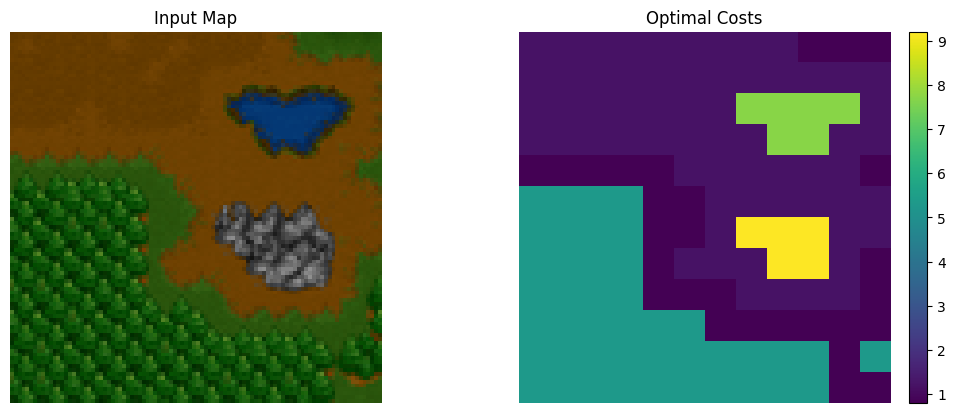


=== EXAMPLE 10 STATISTICS ===
Optimal costs - Range: [0.800, 9.203], Mean: 2.895


In [13]:
def comprehensive_cost_analysis(example_idx=10, num_scatter_examples=20):
    """Create a comprehensive analysis showing both cost maps and scatter plots"""
    
    print(f"=== COMPREHENSIVE COST ANALYSIS ===")
    print(f"Example {example_idx} for detailed cost maps, {num_scatter_examples} examples for scatter analysis")
    
    # Part 1: Detailed cost maps for one example
    im = images[example_idx]
    optimal_costs = train_weights[example_idx]
    optimal_path = train_labels[example_idx]
    
    # Get learned costs from both models
    hamming_costs = get_learned_costs(hamming_model, im) if hamming_model else None
    pathcost_costs = get_learned_costs(pathcost_model, im) if pathcost_model else None
    
    # Create figure with cost maps and scatter plots
    fig = plt.figure(figsize=(20, 12))
    
    # Top row: Cost maps
    num_cost_plots = 2 + (hamming_costs is not None) + (pathcost_costs is not None)
    
    # Input map
    ax1 = plt.subplot(3, 4, 1)
    ax1.imshow(im.astype(np.uint8))
    ax1.set_title("Input Map")
    ax1.axis('off')
    
    # Optimal costs
    ax2 = plt.subplot(3, 4, 2)
    im_optimal = ax2.imshow(optimal_costs, cmap='viridis')
    ax2.set_title("Optimal Costs")
    ax2.axis('off')
    plt.colorbar(im_optimal, ax=ax2, fraction=0.046, pad=0.04)
    
    # HammingLoss learned costs
    if hamming_costs is not None:
        ax3 = plt.subplot(3, 4, 3)
        im_hamming = ax3.imshow(hamming_costs, cmap='viridis')
        ax3.set_title("HammingLoss\nLearned Costs")
        ax3.axis('off')
        plt.colorbar(im_hamming, ax=ax3, fraction=0.046, pad=0.04)
    
    # PathCostLoss learned costs
    if pathcost_costs is not None:
        ax4 = plt.subplot(3, 4, 4)
        im_pathcost = ax4.imshow(pathcost_costs, cmap='viridis')
        ax4.set_title("PathCostLoss\nLearned Costs")
        ax4.axis('off')
        plt.colorbar(im_pathcost, ax=ax4, fraction=0.046, pad=0.04)
    
    # Second row: Difference maps
    if hamming_costs is not None:
        ax5 = plt.subplot(3, 4, 5)
        diff_hamming = hamming_costs - optimal_costs
        im_diff_hamming = ax5.imshow(diff_hamming, cmap='RdBu_r', vmin=-np.max(np.abs(diff_hamming)), vmax=np.max(np.abs(diff_hamming)))
        ax5.set_title("HammingLoss\nDifference from Optimal")
        ax5.axis('off')
        plt.colorbar(im_diff_hamming, ax=ax5, fraction=0.046, pad=0.04)
        
    if pathcost_costs is not None:
        ax6 = plt.subplot(3, 4, 6)
        diff_pathcost = pathcost_costs - optimal_costs
        im_diff_pathcost = ax6.imshow(diff_pathcost, cmap='RdBu_r', vmin=-np.max(np.abs(diff_pathcost)), vmax=np.max(np.abs(diff_pathcost)))
        ax6.set_title("PathCostLoss\nDifference from Optimal")
        ax6.axis('off')
        plt.colorbar(im_diff_pathcost, ax=ax6, fraction=0.046, pad=0.04)
    
    # Third row: Scatter plots from multiple examples
    # Collect data for scatter plots
    optimal_all = []
    hamming_all = []
    pathcost_all = []
    
    for i in range(min(num_scatter_examples, len(images))):
        opt_costs = train_weights[i].flatten()
        optimal_all.extend(opt_costs)
        
        if hamming_model:
            h_costs = get_learned_costs(hamming_model, images[i])
            if h_costs is not None:
                hamming_all.extend(h_costs.flatten())
        
        if pathcost_model:
            p_costs = get_learned_costs(pathcost_model, images[i])
            if p_costs is not None:
                pathcost_all.extend(p_costs.flatten())
    
    # HammingLoss scatter plot
    if hamming_all:
        ax7 = plt.subplot(3, 4, 9)
        optimal_subset = optimal_all[:len(hamming_all)]
        ax7.scatter(optimal_subset, hamming_all, alpha=0.4, s=1, color='blue')
        
        # Perfect correlation line
        min_val, max_val = min(optimal_subset + hamming_all), max(optimal_subset + hamming_all)
        ax7.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        
        ax7.set_xlabel('Optimal Costs')
        ax7.set_ylabel('HammingLoss Learned')
        ax7.set_title('HammingLoss Scatter')
        ax7.grid(True, alpha=0.3)
        
        # Correlation
        corr = np.corrcoef(optimal_subset, hamming_all)[0, 1]
        ax7.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax7.transAxes,
                bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    
    # PathCostLoss scatter plot
    if pathcost_all:
        ax8 = plt.subplot(3, 4, 10)
        optimal_subset = optimal_all[:len(pathcost_all)]
        ax8.scatter(optimal_subset, pathcost_all, alpha=0.4, s=1, color='orange')
        
        # Perfect correlation line
        min_val, max_val = min(optimal_subset + pathcost_all), max(optimal_subset + pathcost_all)
        ax8.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        
        ax8.set_xlabel('Optimal Costs')
        ax8.set_ylabel('PathCostLoss Learned')
        ax8.set_title('PathCostLoss Scatter')
        ax8.grid(True, alpha=0.3)
        
        # Correlation
        corr = np.corrcoef(optimal_subset, pathcost_all)[0, 1]
        ax8.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax8.transAxes,
                bbox=dict(boxstyle="round", facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print(f"\n=== EXAMPLE {example_idx} STATISTICS ===")
    print(f"Optimal costs - Range: [{optimal_costs.min():.3f}, {optimal_costs.max():.3f}], Mean: {optimal_costs.mean():.3f}")
    
    if hamming_costs is not None:
        corr_h = np.corrcoef(optimal_costs.flatten(), hamming_costs.flatten())[0, 1]
        mse_h = np.mean((optimal_costs - hamming_costs)**2)
        print(f"HammingLoss - Range: [{hamming_costs.min():.3f}, {hamming_costs.max():.3f}], Mean: {hamming_costs.mean():.3f}")
        print(f"HammingLoss - Correlation: {corr_h:.3f}, MSE: {mse_h:.3f}")
    
    if pathcost_costs is not None:
        corr_p = np.corrcoef(optimal_costs.flatten(), pathcost_costs.flatten())[0, 1]
        mse_p = np.mean((optimal_costs - pathcost_costs)**2)
        print(f"PathCostLoss - Range: [{pathcost_costs.min():.3f}, {pathcost_costs.max():.3f}], Mean: {pathcost_costs.mean():.3f}")
        print(f"PathCostLoss - Correlation: {corr_p:.3f}, MSE: {mse_p:.3f}")

# Run the comprehensive analysis
comprehensive_cost_analysis(example_idx=10, num_scatter_examples=20)

# MNIST Min-cost Perfect Matching

Download dataset

In [ ]:

# os.makedirs("mnist_matching", exist_ok=True)
# mnist_matching_url = "https://edmond.mpdl.mpg.de/imeji/exportServlet?format=file&id=http://edmond.mpdl.mpg.de/imeji/item/HrfrAxcoQ049qk4K"
# data_path = "datasets/perfect_matching.tar.gz"
# if not os.path.exists(data_path):
#     print("Downloading dataset...")
#     download_url(mnist_matching_url, data_path)

# print(f"Extracting {data_path} ...")
# f = tarfile.open(data_path, "r:gz")
# f.extractall(path="mnist_matching")
# f.close()
# print("Extracted")



In [ ]:
# data_dir = './mnist_matching/4x4_mnist_nonunique'

# train_prefix = "train"
# data_suffix = "full_images"
# train_inputs = np.load(os.path.join(data_dir, train_prefix + "_" + data_suffix + ".npy"))
# train_labels = np.load(os.path.join(data_dir, train_prefix + "_perfect_matching.npy"))

# images = train_inputs.transpose(0,2,3,1).astype(np.uint8)


# img_idx = 2

# plt.title("Example training data point")
# plt.imshow(images[img_idx][:, :, 0], cmap="gray")


The labels for each datapoint are vectors inidicating each edge that was used in the perfect matching by 0-1 entries. In order to convert this to grid coordinates, the function `edges_from_grid` is useful returning the set of edges as tuples of grid coordinates (y1,x1, y2, x2). The label vector indicates which edges are in the matching from this set, example usage for a grid of dimension 4:

```python
edges = edges_from_grid(4, neighbourhood_fn='4-grid')

```

In [ ]:
# plt.title("Edge label vector")
# plt.imshow(train_labels[img_idx][..., None])

In [ ]:
# labeled_image = perfect_matching_vis(images[img_idx], 4, train_labels[img_idx], color="#e19c24", width=2)
# plt.imshow(labeled_image)

# Country Capitals Travelling Salesman Problem

Download dataset

In [ ]:
# import tarfile
# import urllib.request

# os.makedirs("globe_tsp", exist_ok=True)
# globe_tsp_url = "https://edmond.mpdl.mpg.de/imeji/exportServlet?format=file&id=http://edmond.mpdl.mpg.de/imeji/item/70niNNMFUsmfEyfm"
# data_path = "globe_tsp.tar.gz"
# if not os.path.exists(data_path):
#     print("Downloading dataset...")
#     download_url(globe_tsp_url, data_path)

# print(f"Extracting {data_path} ...")
# f = tarfile.open(data_path, "r:gz")
# f.extractall(path="datasets/globe_tsp")
# f.close()
# print("Extracted")


We've generated random subsets of country capitals from 100 countries. The training dataset contains 10000 instances, each consisting of 10 images of flags as the input and the optimal TSP tour of the corresponding capitals as the label. For each instance it also contains the ground truth distance matrix of the capitals that generate the optimal TSP tour, but the ground truth distance matrix is not used for training.

In [ ]:
# run ``python3 -m pip install git+https://github.com/matplotlib/basemap.git``

The dataset

In [ ]:
# data_dir = './globe_tsp/10_countries_from_100/'

# train_prefix = "train"


# flag_indices = np.load(os.path.join(data_dir, train_prefix + "_indices.npy"))
# country_names, gps, flags = zip(*np.load(os.path.join(data_dir, "countries.npy"), allow_pickle=True))
# distance_matrices = np.load(os.path.join(data_dir, train_prefix + "_distance_matrices.npy"))
# tsp_tours = np.load(os.path.join(data_dir, train_prefix + "_tsp_tours.npy"))

# print("Flags shape: ", np.array(flags).shape)
# print("Gps shape: ", np.array(gps).shape)
# print("Flag indices shape (indicates which flags are used in an instance): ", np.array(flag_indices).shape)
# print("Distance matrices shape: ", distance_matrices.shape)
# print("TSP tours / labels shape: ",  tsp_tours.shape)




Examples of individual flags and training instances

In [ ]:
# fig, ax = plt.subplots(1,3, figsize=(12,12))

# # We have a set of 100 flags with gps data
# flag_idx = 57
# example_flag = flags[flag_idx]
# example_flag_gps = gps[flag_idx]
# example_flag_name = country_names[flag_idx]
# ax[0].imshow(example_flag.astype(np.uint8))
# ax[0].set_title(f"One of 10 flags in input of instance:\n {example_flag_name} at GPS: {example_flag_gps}")

# # Each instance consists of 10 images of flags as the input and the optimal tsp tour 
# # of the corresponding capitals as the label
# idx = 10
# label = tsp_tours[idx]
# distances = distance_matrices[idx]
# flags_indices_in_instance = flag_indices[idx]

# ax[1].set_title("Example TSP tour \n (used as train label)")
# ax[1].imshow(label)
# ax[2].set_title("Ground truth Distance Matrix for instance \n (not used for training)")
# ax[2].imshow(distances.astype(np.float32))


Visualization of the captial locations

In [ ]:
# flags_in_instance = np.array(flags)[flags_indices_in_instance]
# gps_in_instance = np.array(gps)[flags_indices_in_instance]

In [ ]:
# # Only plots the tour segments that are fully visible, i.e. both countries are visible
# plot_tsp_path(gps_in_instance, flags_in_instance, tsp_tours[idx])